# Deep Learning Project on Vegetable Image Data Set
### This project is vegetable detection and recognition using CNN and Transfer Learning
##### Data LInk https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
## Citation for the data: https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# unzipping our zipped dataset
!7z x data.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,40 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 560031432 bytes (535 MiB)

Extracting archive: data.zip
 19% 4096 Open              --
Path = data.zip
Type = zip
Physical Size = 560031432

  0%      2% 617 - Vegetable Images/test/Brinjal/1010.jpg                                                   5% 1075 - Vegetable Images/test/Cabbage/1071.jpg                                                    8% 1707 - Vegetable Images/test/Cauliflower/1156.jpg                                   

# New Section

 **Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense,GlobalAveragePooling2D
import os,pathlib,io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Nadam
import random
import pandas as pd
from sklearn import metrics
from pathlib import Path
import os.path
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.applications.vgg19 import VGG19
from keras.models import Sequential





**Connect with Drive**

In [ ]:
train = '/contain/Vegetable Images/train'
test = '/contain/Vegetable Images/test'
val = '/contain/Vegetable Images/validation'

**Creating DataFrame Using file_path and their respective labels**

In [ ]:

train_dir= Path('/content/Vegetable Images/train')
train_dir = list(train_dir.glob(r'**/*.jpg'))
test_dir= Path('/content/Vegetable Images/test')
test_dir = list(test_dir.glob(r'**/*.jpg'))
val_dir= Path('/content/Vegetable Images/validation')
val_dir = list(val_dir.glob(r'**/*.jpg'))




def img_df(file_path):
   

    labels = [str(file_path[i]).split("/")[-2] \
              for i in range(len(file_path))]

    file_path = pd.Series(file_path, name='File_path').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([file_path, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

df_train = img_df(train_dir)
df_test = img_df(test_dir)
df_val = img_df(val_dir)

In [ ]:
df_test.head()

File_path         Label
0    /content/Vegetable Images/test/Cabbage/1033.jpg       Cabbage
1     /content/Vegetable Images/test/Tomato/1081.jpg        Tomato
2  /content/Vegetable Images/test/Bitter_Gourd/13...  Bitter_Gourd
3     /content/Vegetable Images/test/Papaya/1206.jpg        Papaya
4     /content/Vegetable Images/test/Radish/1010.jpg        Radish

In [ ]:
labels =print(f'Labels:\n',df_train.Label.unique())

Labels:
 ['Cucumber' 'Bitter_Gourd' 'Tomato' 'Capsicum' 'Carrot' 'Bottle_Gourd'
 'Cabbage' 'Broccoli' 'Pumpkin' 'Papaya' 'Potato' 'Cauliflower' 'Radish'
 'Bean' 'Brinjal']


**Count the Number of Images for each categories**

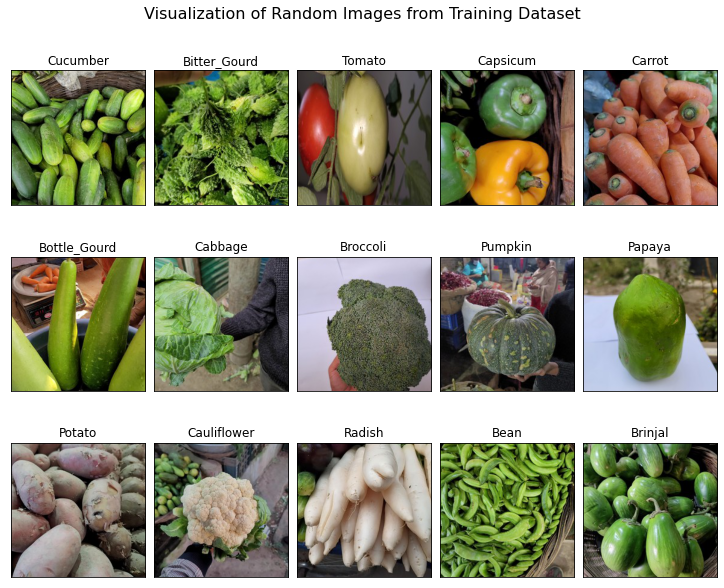

In [ ]:
# Display some pictures of the dataset
df_unique = df_train.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
plt.suptitle('Visualization of Random Images from Training Dataset',fontsize = 16,y = 1.05)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.File_path[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()


**Generating the Image Data for Our Models**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255.)
test_datagen = ImageDataGenerator(
    rescale=1/255.)
valid_datagen = ImageDataGenerator(
    rescale=1/255.)
print('\n\033[1m' + 'Train Data' + '\033[0m\n')

train_data = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='File_path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
print('\n\033[1m' + 'Validation Data' + '\033[0m\n')

val_data = valid_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='File_path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
print('\n\033[1m' + 'Test Data' + '\033[0m\n')

test_data = test_datagen.flow_from_dataframe(
    dataframe= df_test,
    x_col='File_path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



Train Data

Found 15000 validated image filenames belonging to 15 classes.

Validation Data

Found 3000 validated image filenames belonging to 15 classes.

Test Data

Found 3000 validated image filenames belonging to 15 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True


**Optimizer - RMSprop**

In [ ]:
callbacks = myCallback()


model1 = tf.keras.Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(15,activation='softmax')
])
model1.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])
start = time.time()
    
history1 = model1.fit(train_data,
                     epochs=20,
                     steps_per_epoch=len(train_data),
                     validation_data=val_data,
                     validation_steps=len(val_data),
                    callbacks = [callbacks])
end = time.time()
print('Execution Time:',round((end-start)/60,2),'minutes')

Epoch 1/20
 26/469 [>.............................] - ETA: 2:07 - loss: 2.7043 - accuracy: 0.1695

KeyboardInterrupt: ignored

**Plotting Validation and Training Accuracy Development - Optimizer:RMSprop**

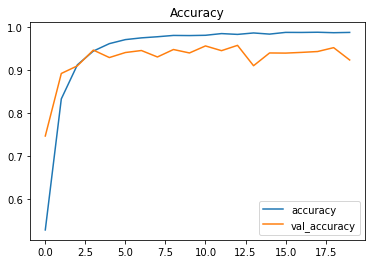

In [ ]:
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

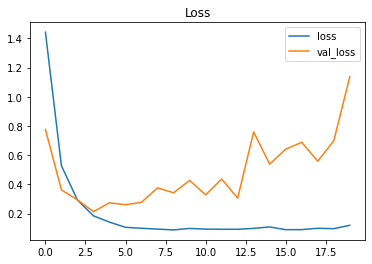

In [ ]:
pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

**Test Accuracy - Optimizer:RMSprop**

In [ ]:
from sklearn.metrics import accuracy_score
pred1 = model1.predict(test_data)
pred1 = np.argmax(pred1,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred1]

y_test = [labels[k] for k in test_data.classes]
acc1 = accuracy_score(y_test, pred1)
print(f'Accuracy on the test set: {100*acc1:.2f}%')

Accuracy on the test set: 92.40%


**Confusion Matrix - Optimizer:RMSprop**

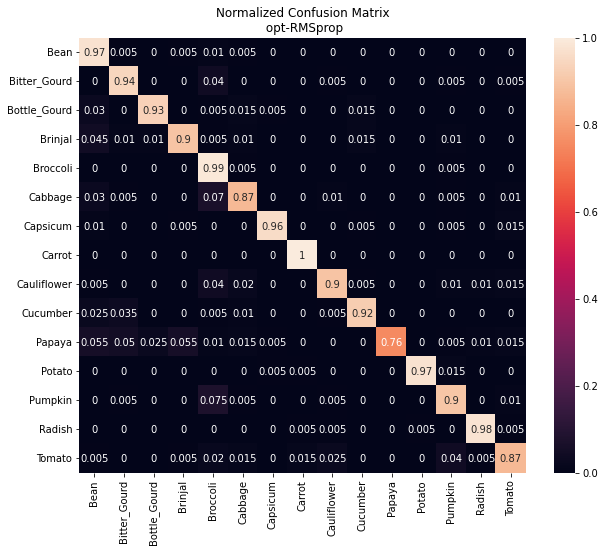

In [ ]:
cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\n opt-RMSprop')
plt.show()

**Random Test - Optimizer:RMSprop**

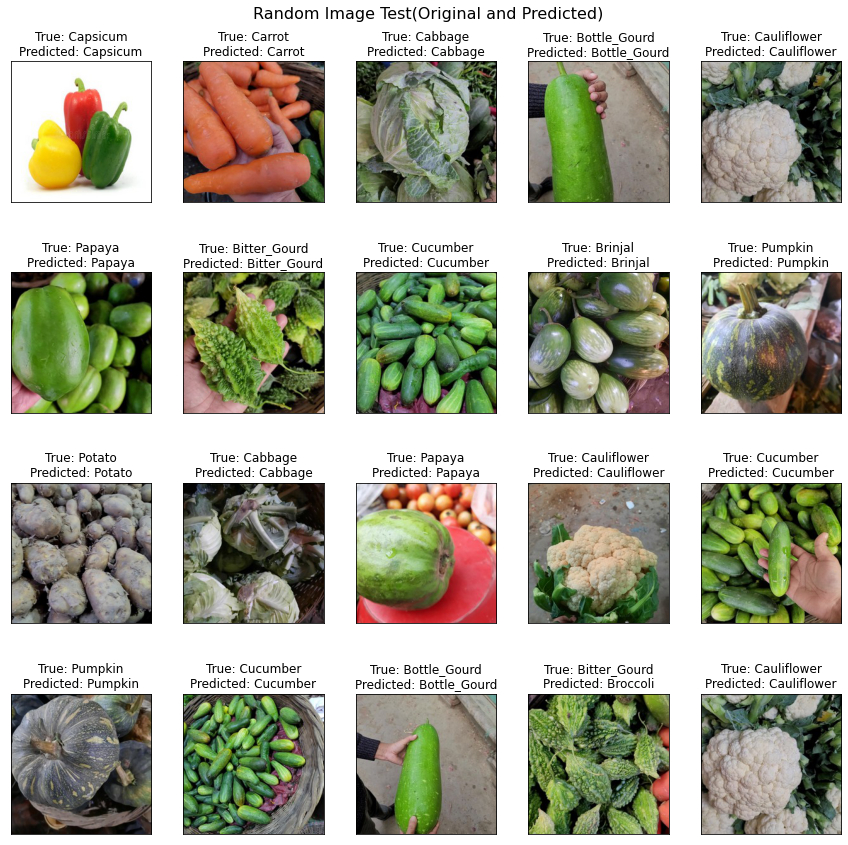

In [ ]:
import random
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
random_test_indx = random.sample(range(1000),20)
plt.suptitle('Random Image Test(Original and Predicted)',fontsize = 16,y = 1)
ax_list = [j for i,j in enumerate(axes.flat)]
for i, ax in zip(random_test_indx,ax_list):
  ax.imshow(plt.imread(df_test.File_path.iloc[i]))
  ax.set_title(f"True: {df_test.Label.iloc[i]}\nPredicted: {pred1[i]}")
  
plt.tight_layout()
plt.show()

**Optimizer - Adam**

In [ ]:
model2 = tf.keras.Sequential([
    Input(shape=(224,224,3)),
    Conv2D(128,3,activation='tanh'),
    MaxPooling2D(2),
    Dropout(.2),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(15,activation='softmax')
])
model2.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
             metrics=['accuracy'])
start = time.time()
    
history2 = model2.fit(train_data,
                     epochs=20,
                     steps_per_epoch=len(train_data),
                     validation_data=val_data,
                     validation_steps=len(val_data), callbacks = [callbacks])
end = time.time()
print('Execution Time:',round((end-start)/60,2),'minutes')

Epoch 1/20
469/469 [==============================] - 559s 1s/step - loss: 1.1789 - accuracy: 0.6085 - val_loss: 0.6086 - val_accuracy: 0.8103
Epoch 2/20
469/469 [==============================] - 550s 1s/step - loss: 0.4943 - accuracy: 0.8413 - val_loss: 0.3977 - val_accuracy: 0.8803
Epoch 3/20
469/469 [==============================] - 543s 1s/step - loss: 0.2796 - accuracy: 0.9131 - val_loss: 0.3146 - val_accuracy: 0.9043
Epoch 4/20
469/469 [==============================] - 542s 1s/step - loss: 0.2000 - accuracy: 0.9382 - val_loss: 0.1938 - val_accuracy: 0.9440
Epoch 5/20
469/469 [==============================] - 539s 1s/step - loss: 0.1666 - accuracy: 0.9495 - val_loss: 0.2652 - val_accuracy: 0.9210
Epoch 6/20
469/469 [==============================] - 542s 1s/step - loss: 0.1260 - accuracy: 0.9596 - val_loss: 0.1812 - val_accuracy: 0.9507
Epoch 7/20
469/469 [==============================] - 535s 1s/step - loss: 0.1202 - accuracy: 0.9619 - val_loss: 0.2237 - val_accuracy: 0.9397

**Plotting Validation and Training Accuracy Development - Optimizer:Adam**

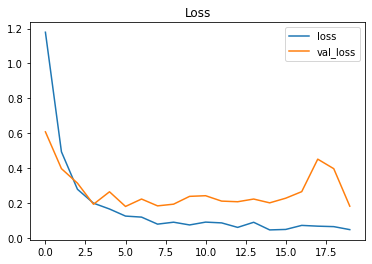

In [ ]:
pd.DataFrame(history2.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

**Test and Predictions**

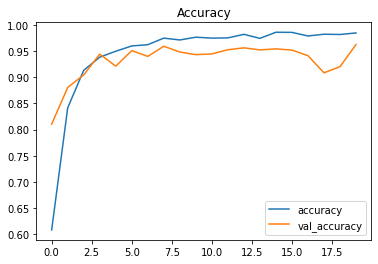

In [ ]:
pd.DataFrame(history2.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

**Test Accuracy - Optimizer:Adam**

In [ ]:
pred2 = model2.predict(test_data)
pred2 = np.argmax(pred2,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred2]

y_test = [labels[k] for k in test_data.classes]
# Checking Test Accracy

from sklearn.metrics import accuracy_score
acc2 = accuracy_score(y_test, pred2)
print(f'Accuracy on the test set: {100*acc2:.2f}%')

Accuracy on the test set: 96.60%


**Confusion Matrix - Optimizer:Adam**

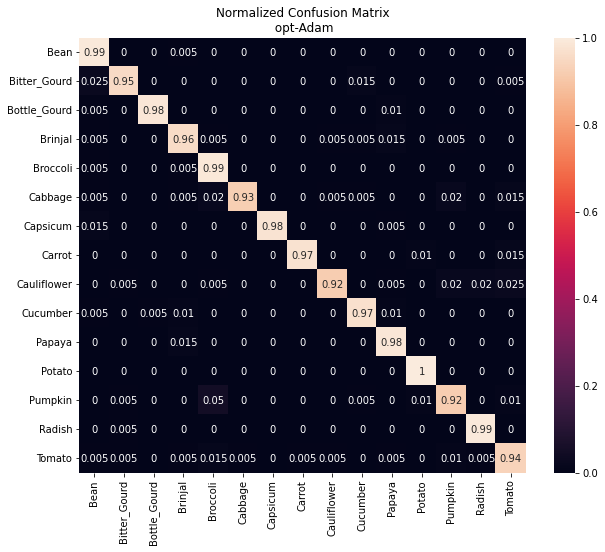

In [ ]:

cf_matrix = confusion_matrix(y_test, pred2, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\n opt-Adam')
plt.show()


***Optimizer- SGD***

In [ ]:
model3 = tf.keras.Sequential([
    Input(shape=(224,224,3)),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.5),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.5),
    Conv2D(32,3,activation='relu'),
    MaxPooling2D(2),
    Dropout(.5),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(15,activation='softmax')
])
model3.compile(loss='categorical_crossentropy',
             optimizer='SGD',
             metrics=['accuracy'])

start = time.time()   
history3 = model3.fit(train_data,
                     epochs=20,
                     steps_per_epoch=len(train_data),
                     validation_data=val_data,
                     validation_steps=len(val_data),
                       callbacks = [callbacks])
end = time.time()
print('Execution Time:',round((end-start)/60,2),'minutes')

Epoch 1/20
469/469 [==============================] - 317s 675ms/step - loss: 2.1636 - accuracy: 0.2803 - val_loss: 1.7487 - val_accuracy: 0.5000
Epoch 2/20
469/469 [==============================] - 293s 624ms/step - loss: 1.3995 - accuracy: 0.5414 - val_loss: 1.4244 - val_accuracy: 0.5407
Epoch 3/20
469/469 [==============================] - 286s 609ms/step - loss: 1.0734 - accuracy: 0.6529 - val_loss: 1.2257 - val_accuracy: 0.5660
Epoch 4/20
469/469 [==============================] - 285s 608ms/step - loss: 0.8351 - accuracy: 0.7327 - val_loss: 0.9868 - val_accuracy: 0.6850
Epoch 5/20
469/469 [==============================] - 295s 628ms/step - loss: 0.6379 - accuracy: 0.7995 - val_loss: 0.8739 - val_accuracy: 0.7127
Epoch 6/20
469/469 [==============================] - 286s 609ms/step - loss: 0.4844 - accuracy: 0.8472 - val_loss: 0.6071 - val_accuracy: 0.8120
Epoch 7/20
469/469 [==============================] - 285s 607ms/step - loss: 0.3827 - accuracy: 0.8819 - val_loss: 0.5732 -

**Plotting Validation and Training Accuracy Development - Optimizer:SGD**

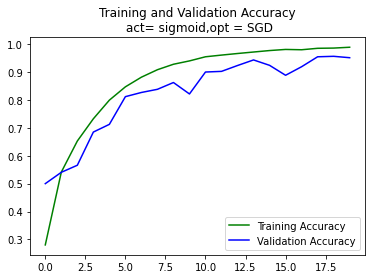

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'g',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy\n act= sigmoid,opt = SGD')
plt.legend(loc = 0)
plt.figure()

plt.show()

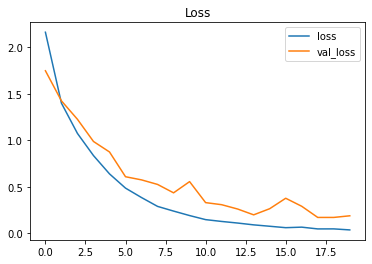

In [ ]:
pd.DataFrame(history3.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

**Test Accuracy - Optimizer:SGD**

In [ ]:
pred3 = model3.predict(test_data)
pred3 = np.argmax(pred3,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred3 = [labels[k] for k in pred3]

y_test = [labels[k] for k in test_data.classes]
# Checking Test Accracy

from sklearn.metrics import accuracy_score
acc3 = accuracy_score(y_test, pred3)
print(f'Accuracy on the test set: {100*acc3:.2f}%')

Accuracy on the test set: 95.83%


**Confusion Matrix - Optimizer:SGD**

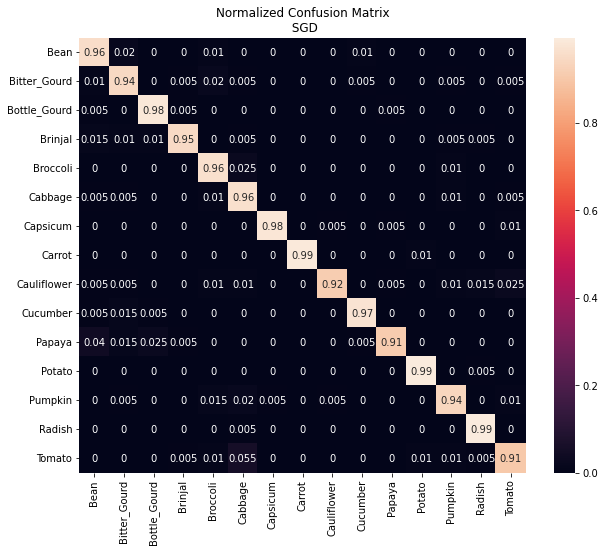

In [ ]:

cf_matrix = confusion_matrix(y_test, pred3, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\n SGD')
plt.show()

***Transfer Learning***


*   ResNet152V2
*   InceptionV3
*   VGG19






**Transfer Learning:ResNet152V2**

In [ ]:
# define base pretrained model
resnet = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),weights='imagenet',include_top=False)

# exclude the redundancy on traning
for i in resnet.layers:
  i.trainable = False

  # construct our model architecture
x = Flatten()(resnet.output)
dense3 = Dense(512,activation = 'relu')(x)
pred_res = Dense(15,activation = 'softmax')(dense3)

# define our model with preprained model
model_res =Model(inputs = resnet.input,outputs = pred_res)
model_res.summary()


# compile
model_res.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

#Training the modle

callbacks = myCallback()
start = time.time()
history_res = model_res.fit_generator(train_data,validation_data = val_data,epochs = 20,callbacks = [callbacks])
end = time.time()
print('Execution Time:',round((end-start)/60,2),'minutes')

234561536/234545216 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
469/469 [==============================] - 653s 1s/step - loss: 2.0398 - accuracy: 0.9567 - val_loss: 0.2810 - val_accuracy: 0.9923
Epoch 2/20
469/469 [==============================] - 634s 1s/step - loss: 0.2704 - accuracy: 0.9921 - val_loss: 0.1664 - val_accuracy: 0.9957
Epoch 3/20
469/469 [==============================] - 634s 1s/step - loss: 0.1282 - accuracy: 0.9963 - val_loss: 0.3293 - val_accuracy: 0.9947
Epoch 4/20
469/469 [==============================] - 621s 1s/step - loss: 0.1108 - accuracy: 0.9967 - val_loss: 0.2338 - val_accuracy: 0.9927
Epoch 5/20
469/469 [==============================] - 627s 1s/step - loss: 0.0673 - accuracy: 0.9978 - val_loss: 0.2013 - val_accuracy: 0.9960
Epoch 6/20
469/469 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9993
Reached 99.9% accuracy so cancelling training!
469/469 [==============================] - 625s 1s/step - loss: 0.0265 - accuracy: 0.9993 - val_loss: 0.1281 - val_accuracy: 0.9957
Execution 

**Loss and Accuracy - ResNet152V2**

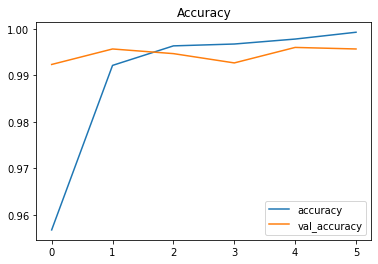

In [ ]:
pd.DataFrame(history_res.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

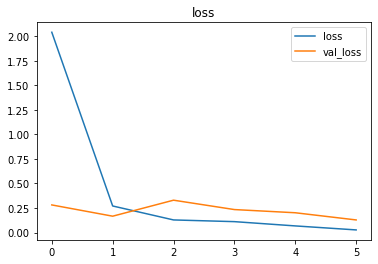

In [ ]:
pd.DataFrame(history_res.history)[['loss','val_loss']].plot()
plt.title("loss")
plt.show()

**Test Accuracy - ResNet152V2**

In [ ]:
pred_res= model_res.predict(test_data)
pred_res = np.argmax(pred_res,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_res = [labels[k] for k in pred_res]

y_test = [labels[k] for k in test_data.classes]
# Checking Test Accracy

from sklearn.metrics import accuracy_score
acc_res = accuracy_score(y_test, pred_res)
print(f'Accuracy on the test set: {100*acc_res:.2f}%')

Accuracy on the test set: 99.53%


**Confusion Matrix - ResNet152V2**

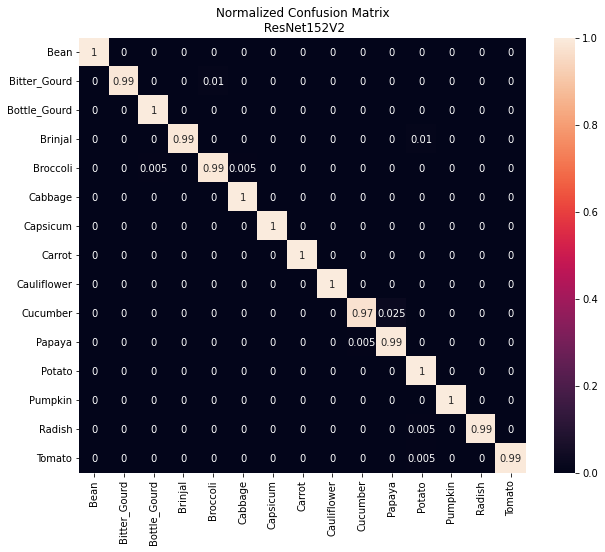

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_res, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\n ResNet152V2')
plt.show()

**Transfer Learning: InceptionV3**

In [ ]:
# define base pretrained model
inception = tf.keras.applications.InceptionV3(input_shape=(224,224,3),weights='imagenet',include_top=False)

# exclude the redundancy on traning
for i in inception.layers:
  i.trainable = False

  # construct our model architecture
x = Flatten()(inception.output)
dense1 = Dense(512,activation = 'relu')(x)
pred_inc = Dense(15,activation = 'softmax')(dense1)

# define our model with preprained model
model_inc =Model(inputs = inception.input,outputs = pred_inc)
model_inc.summary()


# compile
model_inc.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

#Training the modle

callbacks = myCallback()

import time
start = time.time()
history_inc = model_inc.fit_generator(train_data,validation_data = test_data,epochs = 20,callbacks = [callbacks])
end = time.time()
print('Execution Time:',round((end-start)/60,2),'minutes')







87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
469/469 [==============================] - 162s 337ms/step - loss: 3.8476 - accuracy: 0.9098 - val_loss: 1.5086 - val_accuracy: 0.9213
Epoch 2/20
469/469 [==============================] - 158s 336ms/step - loss: 0.3776 - accuracy: 0.9792 - val_loss: 0.2479 - val_accuracy: 0.9807
Epoch 3/20
469/469 [==============================] - 156s 332ms/step - loss: 0.1866 - accuracy: 0.9877 - val_loss: 0.1971 - val_accuracy: 0.9877
Epoch 4/20
469/469 [==============================] - 155s 330ms/step - loss: 0.1158 - accuracy: 0.9931 - val_loss: 0.2486 - val_accuracy: 0.9903
Epoch 5/20
469/469 [==============================] - 156s 333ms/step - loss: 0.1533 - accuracy: 0.9928 - val_loss: 0.3254 - val_accuracy: 0.9873
Epoch 6/20
469/469 [==============================] - 155s 330ms/step - loss: 0.0853 - accuracy: 0.9961 - val_loss: 0.2469 - val_accuracy: 0.9890
Epoch 7/20
469/469 [==============================] - 154s 327ms/step - loss: 0.0915 - accuracy: 0.9949 - val_loss: 0.2558 -

**Evaluation:**
*inceptionV3*

**Loss and Accuracy - InceptionV3**

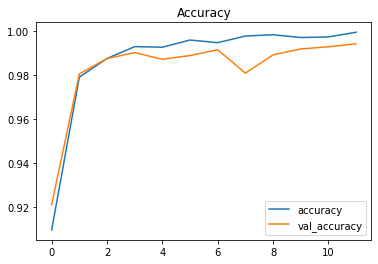

In [ ]:
pd.DataFrame(history_inc.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

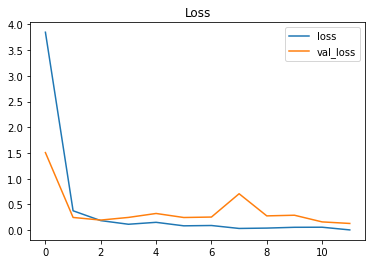

In [ ]:
pd.DataFrame(history_inc.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

**Test Accuracy - InceptionV3**

In [ ]:
pred_inc = model_inc.predict(test_data)
pred_inc = np.argmax(pred_inc,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((j,k) for k,j in labels.items())
pred_inc = [labels[k] for k in pred_inc]

y_test = [labels[k] for k in test_data.classes]

from sklearn.metrics import accuracy_score
acc_inc = accuracy_score(y_test, pred_inc)
print(f'Accuracy on the test set: {100*acc_inc:.2f}%')


Accuracy on the test set: 99.43%


**Confusion Matrix - InceptionV3**

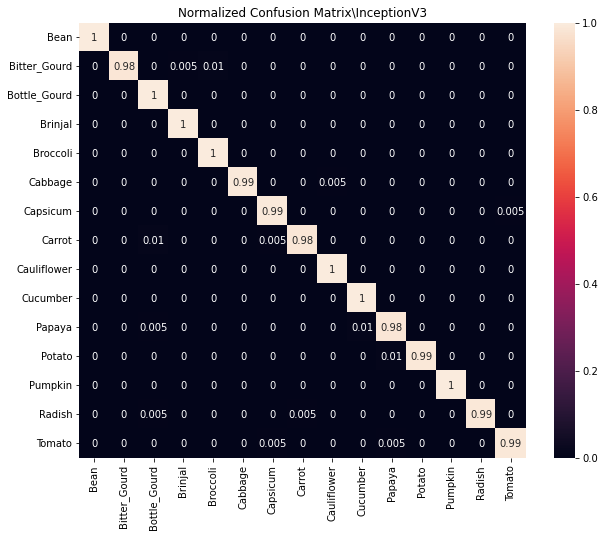

In [ ]:


# confusion matrix
cf_matrix = confusion_matrix(y_test, pred_inc, normalize='true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\InceptionV3')
plt.show()

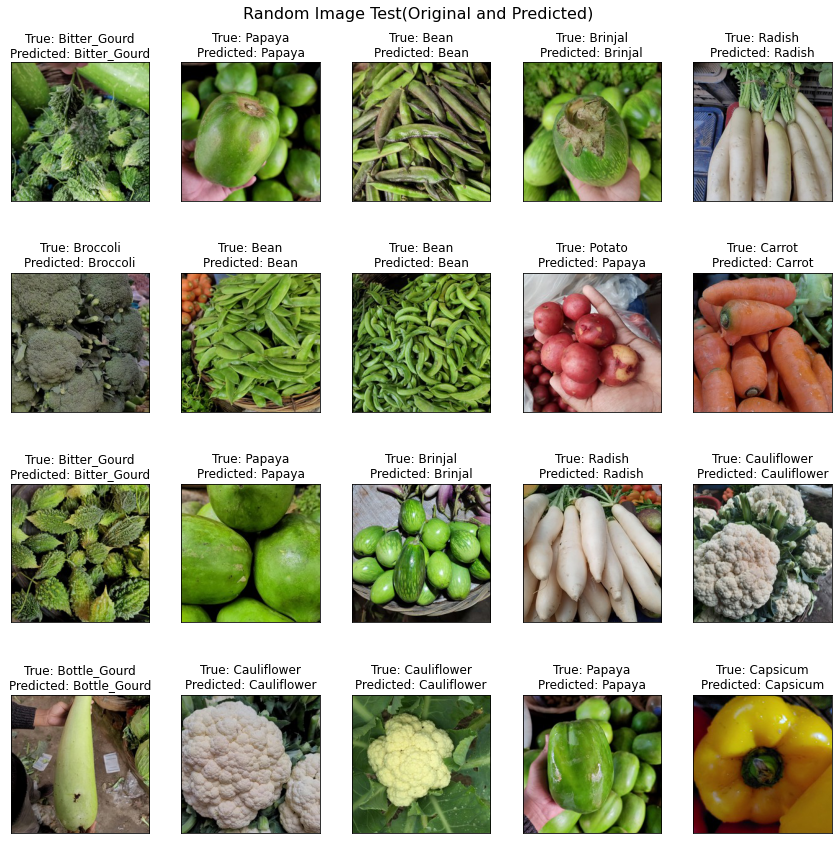

In [ ]:
import random
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
random_test_indx = random.sample(range(1000),20)
plt.suptitle('Random Image Test(Original and Predicted)',fontsize = 16,y = 1)
ax_list = [j for i,j in enumerate(axes.flat)]
for i, ax in zip(random_test_indx,ax_list):
  ax.imshow(plt.imread(df_test.File_path.iloc[i]))
  ax.set_title(f"True: {df_test.Label.iloc[i]}\nPredicted: {pred_inc[i]}")
  
plt.tight_layout()
plt.show()

**Transfer Learning : VGG19**

In [ ]:
# call VGG19


#construct base pretrained_model 
base_vgg = VGG19(input_shape = (224,224,3),weights = 'imagenet',include_top= False)
base_vgg.output

# since pretrained model has be already trained so excluding redundancy on training
for layer in base_vgg.layers:
  layer.trainable = False

    # constructing our model architecture
x = Flatten()(base_vgg.output)
pred_vgg = Dense(15,activation = 'softmax')(x)
model_vgg = Model(inputs = base_vgg.input,outputs= pred_vgg)
model_vgg.summary()

# compiling the inputes and others
model_vgg.compile(loss='categorical_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])


#training the model
callbacks = myCallback()
start = time.time()
history_vgg = model_vgg.fit_generator(train_data,validation_data = test_data,validation_steps = 32,epochs = 20,callbacks = [callbacks])
end = time.time()
print('execution time',(end-start)/60,'minutes')



80150528/80134624 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


469/469 [==============================] - 599s 1s/step - loss: 0.6751 - accuracy: 0.8497 - val_loss: 0.1501 - val_accuracy: 0.9443
Epoch 2/20
469/469 [==============================] - 633s 1s/step - loss: 0.0826 - accuracy: 0.9762 - val_loss: 0.1556 - val_accuracy: 0.9561
Epoch 3/20
469/469 [==============================] - 632s 1s/step - loss: 0.0320 - accuracy: 0.9895 - val_loss: 0.0408 - val_accuracy: 0.9883
Epoch 4/20
469/469 [==============================] - 623s 1s/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0916 - val_accuracy: 0.9805
Epoch 5/20
469/469 [==============================] - 621s 1s/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0389 - val_accuracy: 0.9893
Epoch 6/20
469/469 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9991
Reached 99.9% accuracy so cancelling training!
469/469 [==============================] - 618s 1s/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0118 - val_accuracy: 0.9961
execution time 62.105

**Loss and Accuracy - VGG19**

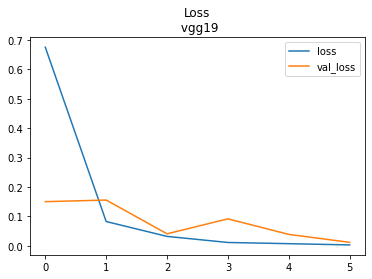

In [ ]:
pd.DataFrame(history_vgg.history)[['loss','val_loss']].plot()
plt.title("Loss\n vgg19")
plt.show()

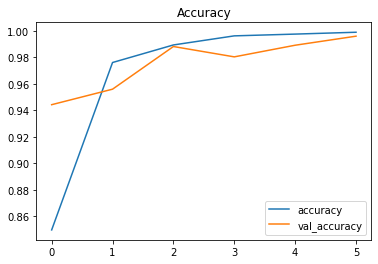

In [ ]:
pd.DataFrame(history_vgg.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

**Test Accuracy - VGG19**

In [ ]:
pred_vgg = model_inc.predict(test_data)
pred_vgg = np.argmax(pred_vgg,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((j,k) for k,j in labels.items())
pred_vgg = [labels[k] for k in pred_vgg]

y_test = [labels[k] for k in test_data.classes]

from sklearn.metrics import accuracy_score
acc_vgg = accuracy_score(y_test, pred_vgg)
print(f'Accuracy on the test set: {100*acc_vgg:.2f}%')

Accuracy on the test set: 99.57%


**Confusion Matrix - VGG19**

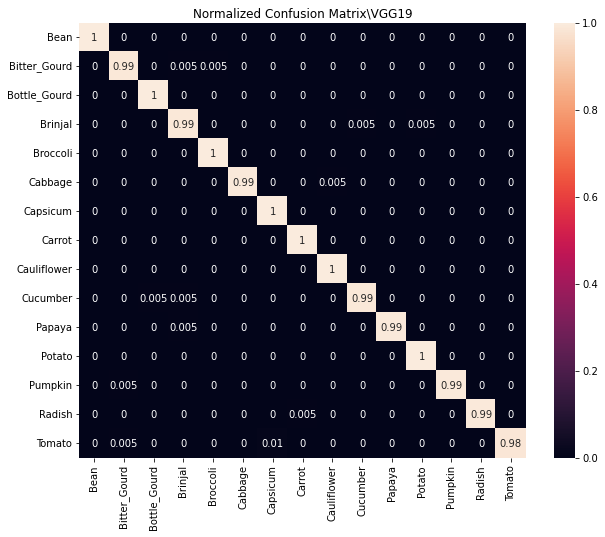

In [ ]:
# confusion matrix
cf_matrix = confusion_matrix(y_test, pred_vgg,normalize = 'true')
plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix\VGG19')
plt.show()

**THE END**